# You'll learn

## ML methods

- Deep NN with keras

Course [slides](https://github.com/Course-bigDataAndML/MLCourse-INFN-2022/blob/master/Slides/Day3/Big%20data%20science%20-%20Day%203%20-%20INFN%202022.pdf)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from pyspark.ml.feature import VectorAssembler

np.random.seed(1337)  # for reproducibility

# Check out these custom functions
from custom_functions import *

#### Remember to start spark by clicking on the square icon all the way to the right

Setup and restart the Spark context with our configuration

In [4]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

# get token to authenticate to minio storage
!eval `oidc-keychain` > /dev/null && oidc-token dodas --time=3600 > /tmp/token
with open('/tmp/token') as f:
    token = f.readlines()[0].split("\n")[0]

# build Spark configuration options    
conf = setupSpark(token)

# to update Spark config, we need first to stop the spark context
SparkContext.stop(sc)

# Then create first spark context, and then session
sc = SparkContext(conf = conf)
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# check if Spark is there
sc

<SparkContext master=k8s://https://kubernetes:443 appName=MyApp>

Keras training is not distributed, still we use spark to read in the input data

In [5]:
# read in input data
inputFile = "s3a://scratch/legger/higgs/Higgs100k.parquet"

%time df = spark.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

total_events = df.count()
print(df)
print(len(df.columns))
print('There are '+str(total_events)+' events')

CPU times: user 8.56 ms, sys: 201 µs, total: 8.76 ms
Wall time: 5.72 s
DataFrame[label: double, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet1_pt: double, jet1_eta: double, jet1_phi: double, jet1_b-tag: double, jet2_pt: double, jet2_eta: double, jet2_phi: double, jet2_b-tag: double, jet3_pt: double, jet3_eta: double, jet3_phi: double, jet3_b-tag: double, jet4_pt: double, je4_eta: double, jet4_phi: double, jet4_b-tag: double, m_jj: double, m_jjj: double, m_lv: double, m_jlv: double, m_bb: double, m_wbb: double, m_wwbb: double]
29
There are 99999 events


In [16]:
#df.show()  #trasforma dato spark in dato che piace a keras
X, y, X_test, y_test = prepareData(df, 0.2)

print('Events for training '+str(len(y)))
print('Events for validation '+str(len(y_test)))

Events for training 79962
Events for validation 20037


# Exercise 1

- documentation: https://keras.io/getting-started/sequential-model-guide/
- Build (compile) a Keras Sequential model (call it *model*)
  - 1 hidden layer  with 100 neurons, activation ReLU (put in the correct input_shape!)
  - 1 ouput layer with activation sigmoid
  - use Adam optimiser
  - use binary_crossentropy loss
  - use accuracy metrics 

In [17]:
# now let's first look at NN in keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


# define the model
model = Sequential(
    [
        Dense(100, activation="relu",  input_shape=(28,)),
        Dense(1, activation="sigmoid"),
    ]
)

##nella soluzione fatto così
##model = Sequential()
##model.add(Dense(100, activation='relu', input_shape=(28,)))
##model.add(Dense(1, activation='sigmoid'))


# Compile model
# model.compile(???)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [19]:
%%time
history = model.fit(X, y, batch_size=128, epochs=20, validation_data=(X_test, y_test), callbacks=[es]) #, verbose=0)

Epoch 1/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6604 - accuracy: 0.5978 - val_loss: 0.6430 - val_accuracy: 0.6200
Epoch 2/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6370 - accuracy: 0.6342 - val_loss: 0.6311 - val_accuracy: 0.6422
Epoch 3/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6289 - accuracy: 0.6454 - val_loss: 0.6252 - val_accuracy: 0.6465
Epoch 4/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6216 - accuracy: 0.6540 - val_loss: 0.6176 - val_accuracy: 0.6552
Epoch 5/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6148 - accuracy: 0.6613 - val_loss: 0.6160 - val_accuracy: 0.6517
Epoch 6/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6098 - accuracy: 0.6671 - val_loss: 0.6105 - val_accuracy: 0.6718
Epoch 7/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6046 - accuracy: 0.6737 - val_loss: 0.6049 - val_accuracy: 0.6734
Epoch 

<IPython.core.display.Javascript object>


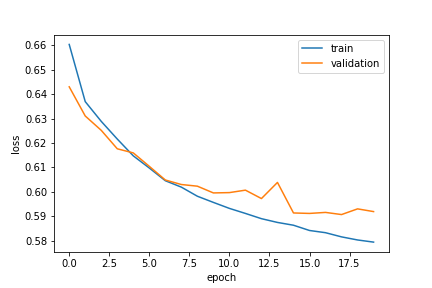

In [20]:
plotVsEpoch(history, 'loss')

<IPython.core.display.Javascript object>


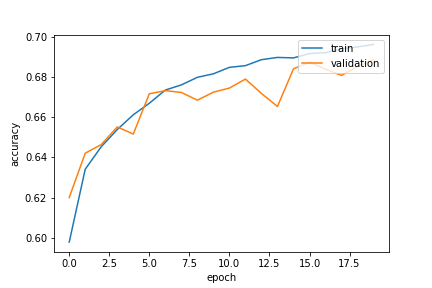

In [21]:
plotVsEpoch(history, 'accuracy')

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               2900      
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________


627/627 [==============================] - 1s 2ms/step


<IPython.core.display.Javascript object>


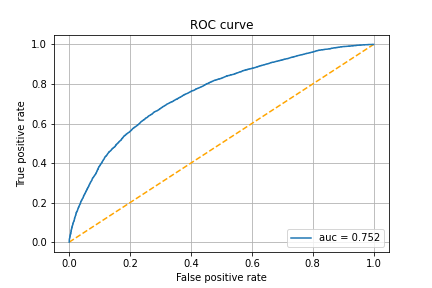

In [23]:
# apply model to get predictions on test set
y_pred = model.predict(X_test)

#draw ROC
drawROC2(y_test, y_pred)

In [25]:
#do signal vs background plot
m_bb = X_test[:,25]

def isSignal(x, y):
    if (y>=0.5):
        return x
    else: 
        return -1.
    
def isBackground(x, y):
    if (y<0.5):
        return x
    else: 
        return -1.
isSignalNP = np.vectorize(isSignal)
isBackgroundNP = np.vectorize(isBackground)

m_bb_signal = isSignalNP(m_bb, y_test)
m_bb_background = isBackgroundNP(m_bb, y_test)
m_bb_signal_pred = isSignalNP(m_bb, y_pred[:,0])
m_bb_background_pred = isBackgroundNP(m_bb, y_pred[:,0])

<IPython.core.display.Javascript object>


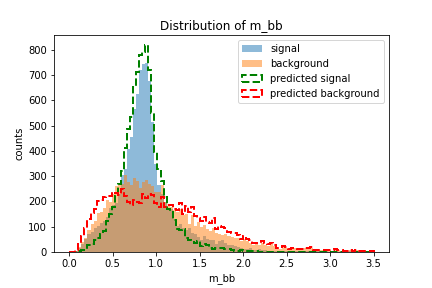

In [26]:
f, ax = plt.subplots()
plt.hist(m_bb_signal, bins = 100, range=[0, 3.5], alpha=0.5, label='signal') 
plt.hist(m_bb_background, bins = 100, range=[0, 3.5], alpha=0.5, label='background') 
plt.hist(m_bb_signal_pred, bins = 100, range=[0, 3.5], label='predicted signal', histtype='step',
        linestyle='--', color='green', linewidth=2) 
plt.hist(m_bb_background_pred, bins = 100, range=[0, 3.5], label='predicted background', histtype='step',
        linestyle='--', color='red', linewidth=2) 
plt.title("histogram") 
ax.set_xlabel('m_bb')
ax.set_ylabel('counts')
ax.legend()
ax.set_title("Distribution of m_bb")
plt.show()
f.savefig("SignalvsBackgroundPred.pdf", bbox_inches='tight')

# Exercise 2

- play with the model parameters and see if you can improve the performances (try to add hidden layers)
- try to increase the number of epochs for training, is the model improving?
- If statistics is limited in validation sample, try to play with different ratios (60:40, 70:30)
- Under which conditions are you overfitting?
- how is training time affected by the number of parameters?
- how is signal versus background separation affected (check different variables)